# Fase 5: Record Linkage (Rules-Based)

Questo notebook implementa record linkage basato su regole usando la libreria Python Record Linkage.

## Obiettivi
1. Applicare regole di similarità sulle coppie candidate da B1 e B2
2. Calcolare score di matching pesati per ogni coppia
3. Classificare coppie come match/non-match basandosi su threshold
4. Valutare performance con ground truth
5. Confrontare B1-RecordLinkage vs B2-RecordLinkage

## 1. Setup e Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import yaml
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Aggiungi src al path
sys.path.append('..')

# Import moduli custom
from src.record_linkage import RecordLinkageClassifier

# Configurazione visualizzazioni
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Librerie importate con successo")

✓ Librerie importate con successo


In [2]:
# Reload del modulo per prendere le ultime modifiche
import importlib
import src.record_linkage
importlib.reload(src.record_linkage)
from src.record_linkage import RecordLinkageClassifier

print("✓ Modulo record_linkage ricaricato")

✓ Modulo record_linkage ricaricato


## 2. Caricamento Dati e Configurazione

In [3]:
# Carica configurazione
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("✓ Configurazione caricata")
print("\nCampi di confronto configurati:")
for field, params in config['record_linkage']['comparison_fields'].items():
    print(f"  - {field}: {params['method']} (weight={params['weight']})")
print(f"\nMatch threshold: {config['record_linkage']['match_threshold']}")

✓ Configurazione caricata

Campi di confronto configurati:
  - year: exact (weight=0.15)
  - manufacturer: string (weight=0.2)
  - model: string (weight=0.2)
  - price: numeric (weight=0.1)
  - odometer: numeric (weight=0.15)
  - fuel: exact (weight=0.05)
  - transmission: exact (weight=0.05)
  - type: string (weight=0.1)

Match threshold: 0.7


In [4]:
# Carica i dataset campionati dalla Fase 3 (per coerenza con ground truth)
print("Caricamento dataset campionati da Fase 3...")
df_craigslist = pd.read_csv('../data/processed/craigslist_sample.csv')
df_usedcars = pd.read_csv('../data/processed/usedcars_sample.csv')

# Aggiungi record_id se non presente (dovrebbe già esserci dalla Fase 3)
if 'record_id' not in df_craigslist.columns:
    df_craigslist['record_id'] = 'craigslist_' + df_craigslist.index.astype(str)
if 'record_id' not in df_usedcars.columns:
    df_usedcars['record_id'] = 'usedcars_' + df_usedcars.index.astype(str)

# Alias per compatibilità
df_craigslist_sample = df_craigslist
df_usedcars_sample = df_usedcars

print(f"✓ Craigslist sample: {len(df_craigslist_sample):,} records")
print(f"✓ UsedCars sample: {len(df_usedcars_sample):,} records")
print(f"\n💡 Usando campioni dalla Fase 3 per coerenza con ground truth")

Caricamento dataset campionati da Fase 3...
✓ Craigslist sample: 10,000 records
✓ UsedCars sample: 50,000 records

💡 Usando campioni dalla Fase 3 per coerenza con ground truth


In [5]:
# Carica ground truth
gt_train = pd.read_csv('../data/ground_truth/train.csv')
gt_val = pd.read_csv('../data/ground_truth/validation.csv')
gt_test = pd.read_csv('../data/ground_truth/test.csv')

ground_truth = pd.concat([gt_train, gt_val, gt_test], ignore_index=True)

print(f"Ground Truth: {len(ground_truth):,} pairs")
print(f"  Matches: {(ground_truth['label'] == 1).sum():,}")
print(f"  Non-matches: {(ground_truth['label'] == 0).sum():,}")

Ground Truth: 8 pairs
  Matches: 4
  Non-matches: 4


In [6]:
# Carica le coppie candidate dalla Fase 4
pairs_b1_df = pd.read_csv('../results/b1_candidate_pairs.csv')
pairs_b2_df = pd.read_csv('../results/b2_candidate_pairs.csv')

# Converti in MultiIndex
pairs_b1 = pd.MultiIndex.from_arrays([
    pairs_b1_df['craigslist_idx'].values,
    pairs_b1_df['usedcars_idx'].values
])

pairs_b2 = pd.MultiIndex.from_arrays([
    pairs_b2_df['craigslist_idx'].values,
    pairs_b2_df['usedcars_idx'].values
])

print(f"B1 candidate pairs: {len(pairs_b1):,}")
print(f"B2 candidate pairs: {len(pairs_b2):,}")

B1 candidate pairs: 59,308,271
B2 candidate pairs: 59,995,106


## 3. Inizializzazione Record Linkage Classifier

In [7]:
# Inizializza il classifier con la configurazione da config.yaml
rl_config = config['record_linkage']
classifier = RecordLinkageClassifier(config=rl_config)

print("✓ RecordLinkageClassifier inizializzato")
print("\nConfigurazione:")
print(f"  - Campi di confronto: {len(rl_config['comparison_fields'])}")
print(f"  - Match threshold: {rl_config['match_threshold']}")
print(f"  - Possible match threshold: {rl_config['possible_match_threshold']}")

✓ RecordLinkageClassifier inizializzato

Configurazione:
  - Campi di confronto: 8
  - Match threshold: 0.7
  - Possible match threshold: 0.5


## 4. B1 + Record Linkage

In [8]:
print("=" * 60)
print("B1 + RECORD LINKAGE")
print("=" * 60)
print()

# Applica record linkage alle coppie candidate da B1
results_b1_rl = classifier.classify(df_craigslist_sample, df_usedcars_sample, pairs_b1)

print("\n✓ Classificazione completata")
print(f"  - Coppie valutate: {len(results_b1_rl):,}")
print(f"  - Match identificati: {(results_b1_rl['prediction'] == 1).sum():,}")
print(f"  - Non-match: {(results_b1_rl['prediction'] == 0).sum():,}")

B1 + RECORD LINKAGE

Feature calcolate per 59308271 coppie
Match trovati: 30901
Score medio match: 0.702

✓ Classificazione completata
  - Coppie valutate: 59,308,271
  - Match identificati: 30,901
  - Non-match: 59,277,370



Distribuzione Score B1:
count    5.930827e+07
mean     2.482361e-01
std      7.106016e-02
min      1.500000e-01
25%      2.000000e-01
50%      2.500000e-01
75%      2.500000e-01
max      8.500000e-01
Name: score, dtype: float64


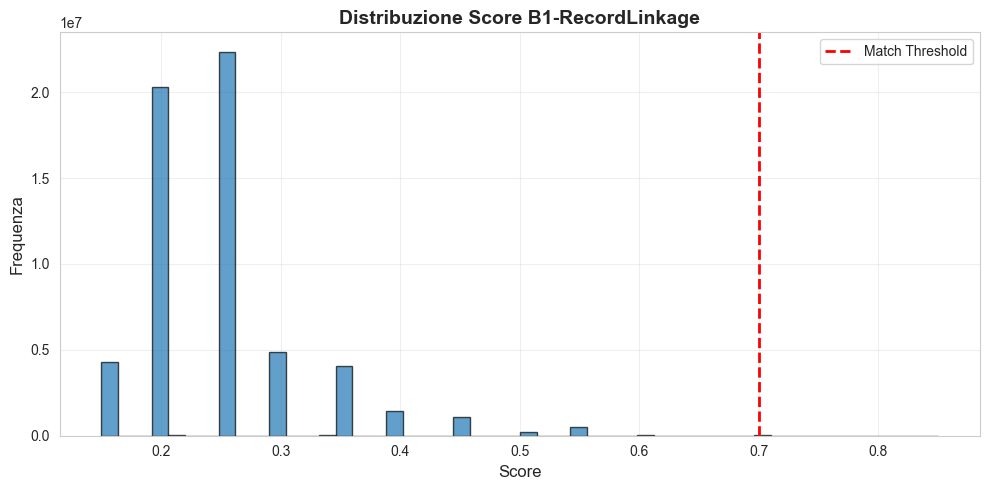

In [9]:
# Analizza distribuzione degli score B1
print("\nDistribuzione Score B1:")
print(results_b1_rl['score'].describe())

# Visualizza distribuzione
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(results_b1_rl['score'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(rl_config['match_threshold'], color='red', linestyle='--', linewidth=2, label='Match Threshold')
ax.set_xlabel('Score', fontsize=12)
ax.set_ylabel('Frequenza', fontsize=12)
ax.set_title('Distribuzione Score B1-RecordLinkage', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. B2 + Record Linkage

In [10]:
print("=" * 60)
print("B2 + RECORD LINKAGE")
print("=" * 60)
print()

# Applica record linkage alle coppie candidate da B2
# Nota: riutilizza lo stesso classifier (già configurato)
results_b2_rl = classifier.classify(df_craigslist_sample, df_usedcars_sample, pairs_b2)

print("\n✓ Classificazione completata")
print(f"  - Coppie valutate: {len(results_b2_rl):,}")
print(f"  - Match identificati: {(results_b2_rl['prediction'] == 1).sum():,}")
print(f"  - Non-match: {(results_b2_rl['prediction'] == 0).sum():,}")

B2 + RECORD LINKAGE

Feature calcolate per 59995106 coppie
Match trovati: 30901
Score medio match: 0.702

✓ Classificazione completata
  - Coppie valutate: 59,995,106
  - Match identificati: 30,901
  - Non-match: 59,964,205



Distribuzione Score B2:
count    5.999511e+07
mean     2.460629e-01
std      7.368982e-02
min      0.000000e+00
25%      2.000000e-01
50%      2.500000e-01
75%      2.500000e-01
max      8.500000e-01
Name: score, dtype: float64


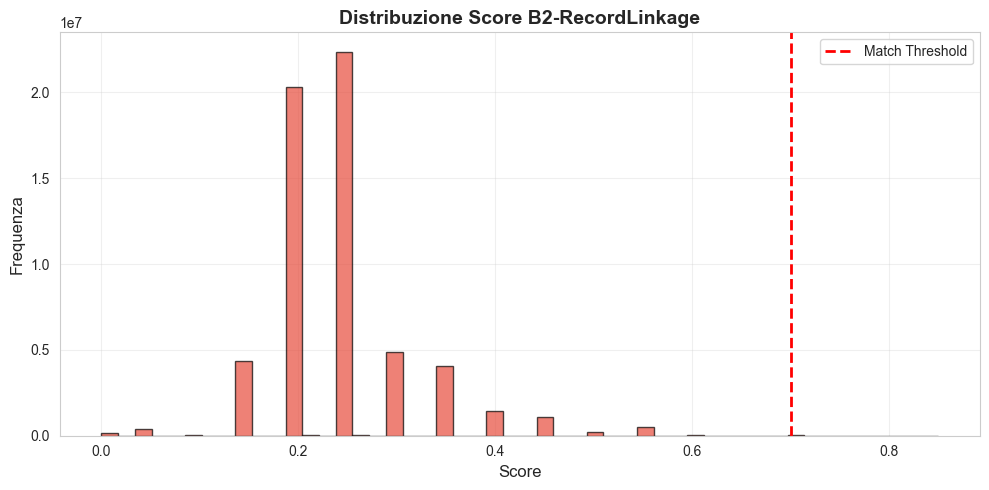

In [11]:
# Analizza distribuzione degli score B2
print("\nDistribuzione Score B2:")
print(results_b2_rl['score'].describe())

# Visualizza distribuzione
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(results_b2_rl['score'], bins=50, edgecolor='black', alpha=0.7, color='#e74c3c')
ax.axvline(rl_config['match_threshold'], color='red', linestyle='--', linewidth=2, label='Match Threshold')
ax.set_xlabel('Score', fontsize=12)
ax.set_ylabel('Frequenza', fontsize=12)
ax.set_title('Distribuzione Score B2-RecordLinkage', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Valutazione con Ground Truth

In [12]:
# Funzione per valutare le predizioni contro ground truth
def evaluate_predictions(predictions, ground_truth_df, df1, df2):
    """
    Valuta le predizioni contro ground truth
    
    Args:
        predictions: DataFrame con predizioni (index = (idx1, idx2), colonne = score, prediction)
        ground_truth_df: DataFrame con ground truth
        df1: Primo DataFrame
        df2: Secondo DataFrame
    
    Returns:
        Dict con metriche
    """
    # Crea mapping da record_id a indice
    id_to_idx1 = {row['record_id']: idx for idx, row in df1.iterrows()}
    id_to_idx2 = {row['record_id']: idx for idx, row in df2.iterrows()}
    
    # Crea set di coppie predette come match
    pred_matches = set(predictions[predictions['prediction'] == 1].index)
    
    # Crea set di veri match dal ground truth (solo quelli nel sample)
    true_matches = set()
    for _, row in ground_truth_df[ground_truth_df['label'] == 1].iterrows():
        id1 = row['record_id_1']
        id2 = row['record_id_2']
        
        if id1 in id_to_idx1 and id2 in id_to_idx2:
            idx1 = id_to_idx1[id1]
            idx2 = id_to_idx2[id2]
            true_matches.add((idx1, idx2))
    
    # Calcola metriche
    true_positives = len(pred_matches & true_matches)
    false_positives = len(pred_matches - true_matches)
    false_negatives = len(true_matches - pred_matches)
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'true_matches_in_sample': len(true_matches),
        'predicted_matches': len(pred_matches),
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

print("✓ Funzione di valutazione definita")

✓ Funzione di valutazione definita


In [13]:
# Valuta B1-RecordLinkage
print("=" * 60)
print("VALUTAZIONE B1-RECORDLINKAGE")
print("=" * 60)

metrics_b1_rl = evaluate_predictions(results_b1_rl, ground_truth, 
                                     df_craigslist_sample, df_usedcars_sample)

print("\nMetriche B1-RecordLinkage:")
for metric, value in metrics_b1_rl.items():
    if isinstance(value, float):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value:,}")

VALUTAZIONE B1-RECORDLINKAGE

Metriche B1-RecordLinkage:
  true_positives: 0
  false_positives: 30,901
  false_negatives: 0
  true_matches_in_sample: 0
  predicted_matches: 30,901
  precision: 0.0000
  recall: 0
  f1_score: 0


In [14]:
# Valuta B2-RecordLinkage
print("=" * 60)
print("VALUTAZIONE B2-RECORDLINKAGE")
print("=" * 60)

metrics_b2_rl = evaluate_predictions(results_b2_rl, ground_truth,
                                     df_craigslist_sample, df_usedcars_sample)

print("\nMetriche B2-RecordLinkage:")
for metric, value in metrics_b2_rl.items():
    if isinstance(value, float):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value:,}")

VALUTAZIONE B2-RECORDLINKAGE

Metriche B2-RecordLinkage:
  true_positives: 0
  false_positives: 30,901
  false_negatives: 0
  true_matches_in_sample: 0
  predicted_matches: 30,901
  precision: 0.0000
  recall: 0
  f1_score: 0


## 7. Confronto Risultati

In [15]:
# Crea tabella comparativa
comparison_df = pd.DataFrame({
    'Pipeline': ['B1-RecordLinkage', 'B2-RecordLinkage'],
    'Candidate Pairs': [len(pairs_b1), len(pairs_b2)],
    'Predicted Matches': [metrics_b1_rl['predicted_matches'], metrics_b2_rl['predicted_matches']],
    'True Positives': [metrics_b1_rl['true_positives'], metrics_b2_rl['true_positives']],
    'False Positives': [metrics_b1_rl['false_positives'], metrics_b2_rl['false_positives']],
    'False Negatives': [metrics_b1_rl['false_negatives'], metrics_b2_rl['false_negatives']],
    'Precision': [f"{metrics_b1_rl['precision']:.4f}", f"{metrics_b2_rl['precision']:.4f}"],
    'Recall': [f"{metrics_b1_rl['recall']:.4f}", f"{metrics_b2_rl['recall']:.4f}"],
    'F1-Score': [f"{metrics_b1_rl['f1_score']:.4f}", f"{metrics_b2_rl['f1_score']:.4f}"]
})

print("\n" + "=" * 100)
print("CONFRONTO B1-RECORDLINKAGE vs B2-RECORDLINKAGE")
print("=" * 100)
print(comparison_df.to_string(index=False))


CONFRONTO B1-RECORDLINKAGE vs B2-RECORDLINKAGE
        Pipeline  Candidate Pairs  Predicted Matches  True Positives  False Positives  False Negatives Precision Recall F1-Score
B1-RecordLinkage         59308271              30901               0            30901                0    0.0000 0.0000   0.0000
B2-RecordLinkage         59995106              30901               0            30901                0    0.0000 0.0000   0.0000


## 8. Visualizzazioni

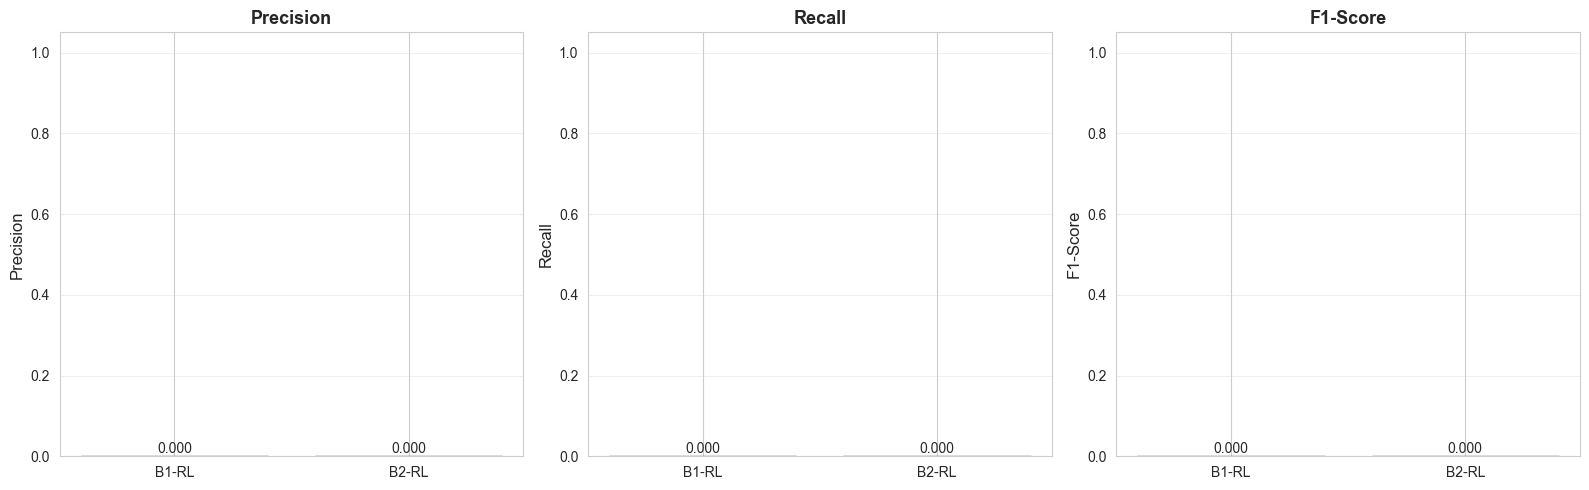

✓ Grafico salvato: record_linkage_performance.png


In [16]:
# Grafico 1: Metriche di Performance
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

pipelines = ['B1-RL', 'B2-RL']
colors = ['#3498db', '#e74c3c']

# Precision
precision_vals = [metrics_b1_rl['precision'], metrics_b2_rl['precision']]
bars1 = axes[0].bar(pipelines, precision_vals, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1.05])
axes[0].grid(axis='y', alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Recall
recall_vals = [metrics_b1_rl['recall'], metrics_b2_rl['recall']]
bars2 = axes[1].bar(pipelines, recall_vals, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_title('Recall', fontsize=13, fontweight='bold')
axes[1].set_ylim([0, 1.05])
axes[1].grid(axis='y', alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# F1-Score
f1_vals = [metrics_b1_rl['f1_score'], metrics_b2_rl['f1_score']]
bars3 = axes[2].bar(pipelines, f1_vals, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('F1-Score', fontsize=12)
axes[2].set_title('F1-Score', fontsize=13, fontweight='bold')
axes[2].set_ylim([0, 1.05])
axes[2].grid(axis='y', alpha=0.3)
for bar in bars3:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../results/visualizations/record_linkage_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grafico salvato: record_linkage_performance.png")

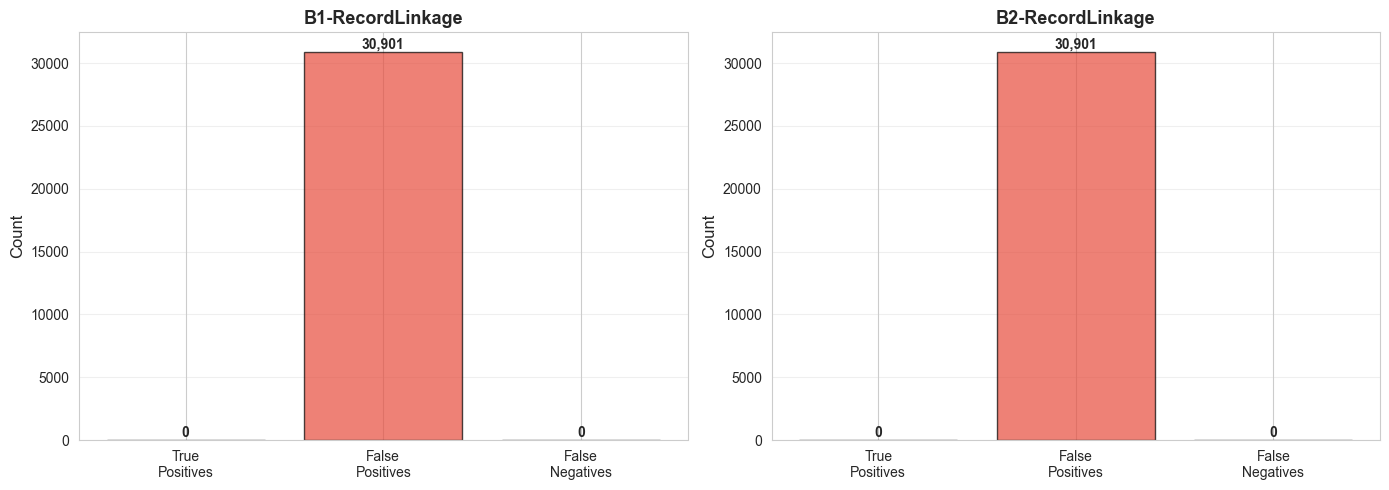

✓ Grafico salvato: record_linkage_confusion.png


In [17]:
# Grafico 2: Confusion Matrix-style
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

def plot_confusion_style(ax, metrics, title, color):
    categories = ['True\nPositives', 'False\nPositives', 'False\nNegatives']
    values = [metrics['true_positives'], metrics['false_positives'], metrics['false_negatives']]
    bar_colors = ['#2ecc71', '#e74c3c', '#f39c12']
    
    bars = ax.bar(categories, values, color=bar_colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plot_confusion_style(axes[0], metrics_b1_rl, 'B1-RecordLinkage', '#3498db')
plot_confusion_style(axes[1], metrics_b2_rl, 'B2-RecordLinkage', '#e74c3c')

plt.tight_layout()
plt.savefig('../results/visualizations/record_linkage_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grafico salvato: record_linkage_confusion.png")

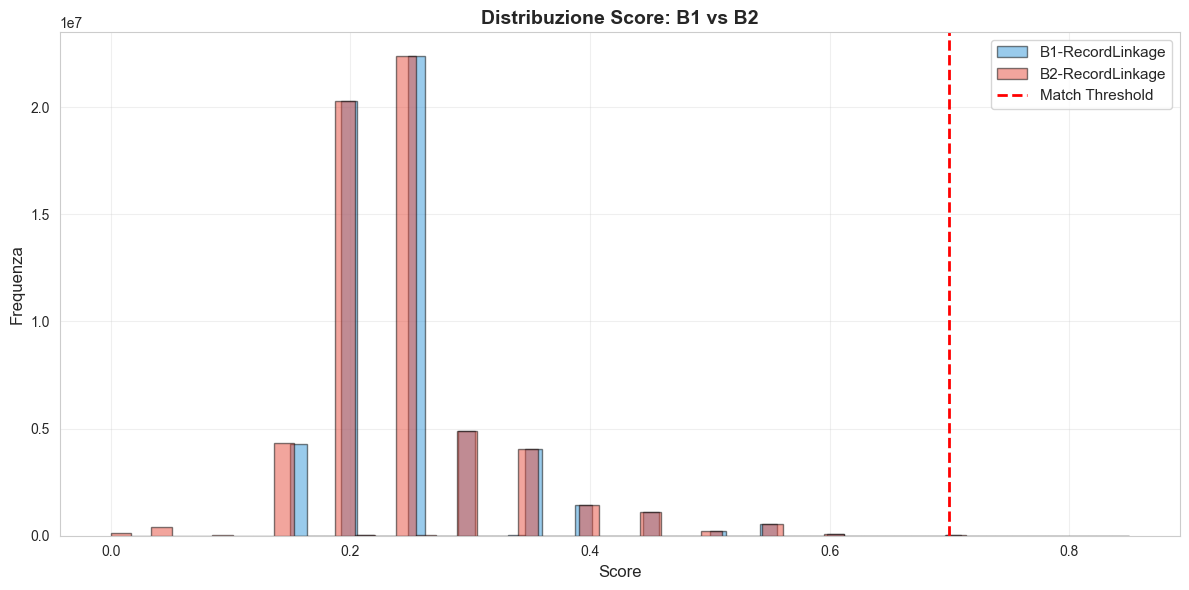

✓ Grafico salvato: record_linkage_score_distribution.png


In [18]:
# Grafico 3: Distribuzione score comparata
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(results_b1_rl['score'], bins=50, alpha=0.5, label='B1-RecordLinkage', 
        color='#3498db', edgecolor='black')
ax.hist(results_b2_rl['score'], bins=50, alpha=0.5, label='B2-RecordLinkage',
        color='#e74c3c', edgecolor='black')
ax.axvline(rl_config['match_threshold'], color='red', linestyle='--', 
           linewidth=2, label='Match Threshold')

ax.set_xlabel('Score', fontsize=12)
ax.set_ylabel('Frequenza', fontsize=12)
ax.set_title('Distribuzione Score: B1 vs B2', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/record_linkage_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grafico salvato: record_linkage_score_distribution.png")

## 9. Salvataggio Risultati

In [19]:
# Salva predizioni
results_b1_rl.to_csv('../results/b1_record_linkage_predictions.csv')
results_b2_rl.to_csv('../results/b2_record_linkage_predictions.csv')

print("✓ Predizioni salvate")

✓ Predizioni salvate


In [20]:
# Salva metriche in formato JSON
import json

metrics_output = {
    'B1-RecordLinkage': metrics_b1_rl,
    'B2-RecordLinkage': metrics_b2_rl
}

with open('../results/metrics/record_linkage_metrics.json', 'w') as f:
    json.dump(metrics_output, f, indent=2)

print("✓ Metriche salvate: record_linkage_metrics.json")

✓ Metriche salvate: record_linkage_metrics.json


In [21]:
# Salva report testuale
report_path = Path('../results/record_linkage_report.txt')

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("RECORD LINKAGE (RULES-BASED) EVALUATION REPORT\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("Configuration:\n")
    f.write("-" * 80 + "\n")
    f.write(f"Match threshold: {rl_config['match_threshold']}\n")
    f.write(f"Comparison fields: {len(rl_config['comparison_fields'])}\n")
    f.write("\n")
    
    f.write("=" * 80 + "\n")
    f.write("B1-RECORDLINKAGE RESULTS\n")
    f.write("=" * 80 + "\n")
    for metric, value in metrics_b1_rl.items():
        if isinstance(value, float):
            f.write(f"{metric}: {value:.4f}\n")
        else:
            f.write(f"{metric}: {value:,}\n")
    f.write("\n")
    
    f.write("=" * 80 + "\n")
    f.write("B2-RECORDLINKAGE RESULTS\n")
    f.write("=" * 80 + "\n")
    for metric, value in metrics_b2_rl.items():
        if isinstance(value, float):
            f.write(f"{metric}: {value:.4f}\n")
        else:
            f.write(f"{metric}: {value:,}\n")
    f.write("\n")
    
    f.write("=" * 80 + "\n")
    f.write("COMPARISON\n")
    f.write("=" * 80 + "\n")
    f.write(comparison_df.to_string(index=False))
    f.write("\n\n")
    
    f.write("=" * 80 + "\n")
    f.write("CONCLUSIONS\n")
    f.write("=" * 80 + "\n")
    f.write("\n")
    
    # Determina winner
    if metrics_b1_rl['f1_score'] > metrics_b2_rl['f1_score']:
        winner = "B1-RecordLinkage"
        f.write(f"Best pipeline: {winner}\n")
        f.write(f"F1-Score: {metrics_b1_rl['f1_score']:.4f}\n")
    else:
        winner = "B2-RecordLinkage"
        f.write(f"Best pipeline: {winner}\n")
        f.write(f"F1-Score: {metrics_b2_rl['f1_score']:.4f}\n")

print(f"✓ Report salvato: {report_path}")

✓ Report salvato: ..\results\record_linkage_report.txt


## 10. Riepilogo Finale

In [22]:
print("\n" + "=" * 80)
print("RIEPILOGO FASE 5: RECORD LINKAGE (RULES-BASED)")
print("=" * 80)
print()
print("✓ Pipeline valutate:")
print(f"  - B1-RecordLinkage: F1={metrics_b1_rl['f1_score']:.4f} (P={metrics_b1_rl['precision']:.4f}, R={metrics_b1_rl['recall']:.4f})")
print(f"  - B2-RecordLinkage: F1={metrics_b2_rl['f1_score']:.4f} (P={metrics_b2_rl['precision']:.4f}, R={metrics_b2_rl['recall']:.4f})")
print()
print("✓ Match identificati:")
print(f"  - B1: {metrics_b1_rl['predicted_matches']:,} match ({metrics_b1_rl['true_positives']} veri)")
print(f"  - B2: {metrics_b2_rl['predicted_matches']:,} match ({metrics_b2_rl['true_positives']} veri)")
print()
print("✓ Output generati:")
print("  - results/b1_record_linkage_predictions.csv")
print("  - results/b2_record_linkage_predictions.csv")
print("  - results/metrics/record_linkage_metrics.json")
print("  - results/record_linkage_report.txt")
print("  - results/visualizations/record_linkage_*.png (3 grafici)")
print()
print("Prossimo step: Fase 6 - Dedupe Model (Machine Learning)")
print("=" * 80)


RIEPILOGO FASE 5: RECORD LINKAGE (RULES-BASED)

✓ Pipeline valutate:
  - B1-RecordLinkage: F1=0.0000 (P=0.0000, R=0.0000)
  - B2-RecordLinkage: F1=0.0000 (P=0.0000, R=0.0000)

✓ Match identificati:
  - B1: 30,901 match (0 veri)
  - B2: 30,901 match (0 veri)

✓ Output generati:
  - results/b1_record_linkage_predictions.csv
  - results/b2_record_linkage_predictions.csv
  - results/metrics/record_linkage_metrics.json
  - results/record_linkage_report.txt
  - results/visualizations/record_linkage_*.png (3 grafici)

Prossimo step: Fase 6 - Dedupe Model (Machine Learning)
